# Creating a Color Magnitude Diagram from Ananke 

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import vaex

In [3]:
%matplotlib inline

## Access Data

In [4]:
# Get the current working directory
current_dir = os.getcwd()

# Go back one directory (to 'src') and then to 'mock'
ananke_file_path = os.path.join(current_dir, "..", "mock", "survey.sim.h5")
print(f"\nOpening data from: {ananke_file_path}")

# Check if the file exists
if os.path.exists(ananke_file_path):
    # Proceed with opening the file
    survey = vaex.open(ananke_file_path)
else:
    print("File does not exist.")


Opening data from: /home/jovyan/home/rubin_mw_mocks/src/analysis/../mock/survey.sim.h5


In [5]:
column_names = survey.column_names
print(column_names)

['age', 'alpha', 'dec', 'dmod', 'feh', 'glat', 'glon', 'grav', 'lsst_gmag', 'lsst_imag', 'lsst_rmag', 'lsst_umag', 'lsst_ymag', 'lsst_zmag', 'lum', 'mact', 'mtip', 'parentid', 'partid', 'px', 'py', 'pz', 'ra', 'rad', 'smass', 'teff', 'vx', 'vy', 'vz']


## Create HR Diagram

The following code was adapted from: https://github.com/athob/anankethon/blob/main/usage_example.ipynb.

In [6]:
hex_cmap = 'cividis'
hex_cmap = plt.get_cmap(hex_cmap)

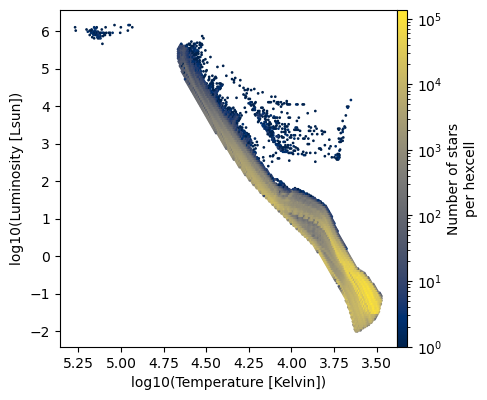

In [7]:
luminosity = survey.lum.to_numpy()
temperature = survey.teff.to_numpy()

fig3,axs=plt.subplots(nrows=1,ncols=3,figsize=(20,8), subplot_kw={'adjustable':'box'})
fig3.subplots_adjust(wspace=0.8)
for ax in axs[1:]: ax.set_visible(False)

hb = axs[0].hexbin(temperature, luminosity, gridsize=(241),
                   bins='log', cmap=hex_cmap)

axs[0].invert_xaxis()
axs[0].set_xlabel('log10(Temperature [Kelvin])')
axs[0].set_ylabel('log10(Luminosity [Lsun])')
axs[0].set_aspect(1.0/axs[0].get_data_ratio())

ax0color_axis = axs[0].inset_axes([1, 0., 0.03, 1.], transform=axs[0].transAxes)

ax0cbar = fig3.colorbar(hb, cax=ax0color_axis, location='right')
ax0cbar.set_label('Number of stars\nper hexcell')

## Testing Distance Modulus

In [8]:
# Extract distance modulus
dmod = survey.dmod.to_numpy()

In [9]:
# Extract distance as parsecs (originally in kpc)
px = survey.px.to_numpy() * 1000
py = survey.py.to_numpy() * 1000
pz = survey.pz.to_numpy() * 1000

distance = np.sqrt(px**2 + py**2 + pz**2)

In [10]:
# Calculate dmod from distance
calculated_dmod = 5 * np.log10(distance) - 5

In [11]:
# Downsample for speed 
downsampled_indices = np.arange(0, len(dmod), 10)

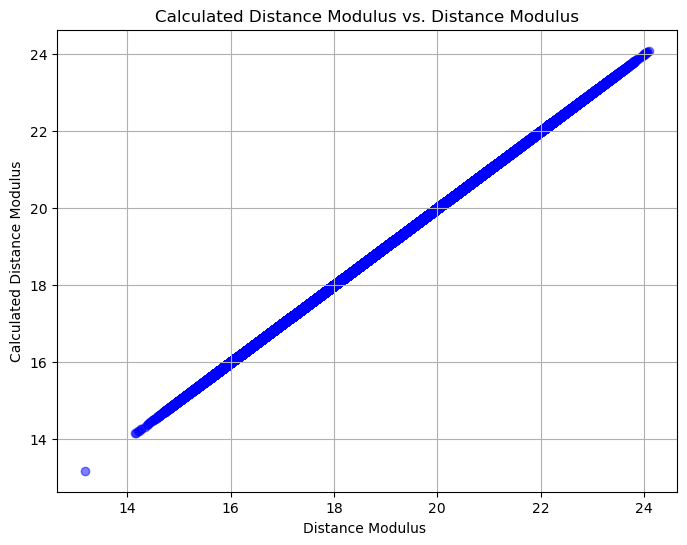

In [12]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
#plt.scatter(dmod, calculated_dmod, alpha=0.5, color='blue')
plt.scatter(dmod[downsampled_indices], calculated_dmod[downsampled_indices], alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('Distance Modulus ')
plt.ylabel('Calculated Distance Modulus')
plt.title('Calculated Distance Modulus vs. Distance Modulus')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

## Testing Magnitudes

In [13]:
# Calculate g-r 
g_mag = survey.lsst_gmag.to_numpy()
r_mag = survey.lsst_rmag.to_numpy()
g_minus_r = g_mag - r_mag

In [14]:
# Calculate M_g
abs_mag_g = g_mag - dmod

In [15]:
# Distance equation (check formula)
abs_mag_g_2 = g_mag - 5 * np.log10(distance) + 5

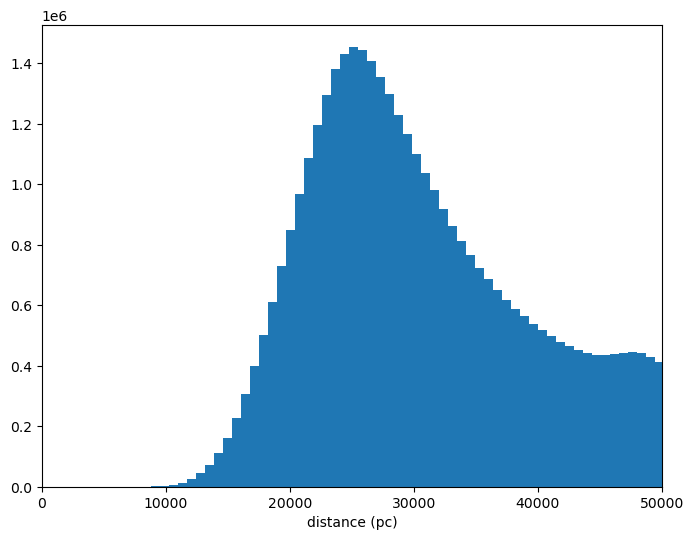

In [17]:
# TESTING - Create a scatter plot of app mag
plt.figure(figsize=(8, 6))
plt.hist(distance, bins=1000)

plt.xlabel("distance (pc)")
plt.xlim(0, 50000)

# Show the plot
plt.show()

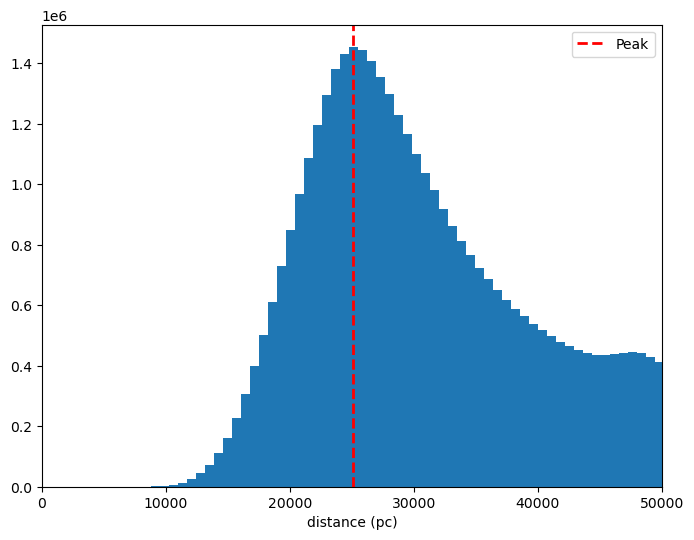

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'distance' is your data
# TESTING - Create a histogram of distances
plt.figure(figsize=(8, 6))
hist, edges, _ = plt.hist(distance, bins=1000)  # Use underscores to capture additional outputs

plt.xlabel("distance (pc)")
plt.xlim(0, 50000)

# Find the bin with the highest frequency (peak)
peak_bin_index = np.argmax(hist)

# Calculate the bin center corresponding to the peak
peak_bin_center = (edges[peak_bin_index] + edges[peak_bin_index + 1]) / 2

# Highlight the peak on the histogram
plt.axvline(peak_bin_center, color='red', linestyle='dashed', linewidth=2, label='Peak')

# Show the plot
plt.legend()
plt.show()

In [51]:
# If our color mag plot doesn't work, add a distance limit, only store the sources left to the peak. 
# Also filter sources out of the galactic plane. 

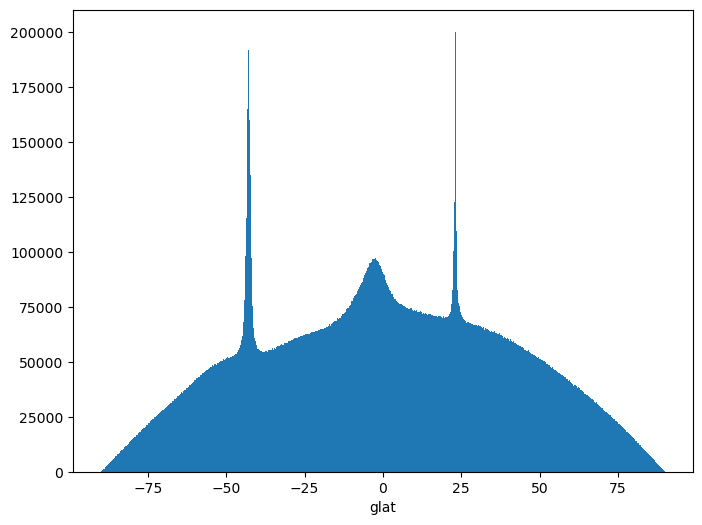

In [52]:
# Histogram of glat
glat = survey.glat.to_numpy()

plt.figure(figsize=(8, 6))
plt.hist(glat, bins=1000)

plt.xlabel("glat")

# Show the plot
plt.show()

In [53]:
# Filter out -15 to 15 glat. 
# After, try removing only the peaks. 
# Finally, create a Mag color diagram but only for the galaxies. Do not use any other filters that we added. 
# Make sure all the samples / filters are parameters

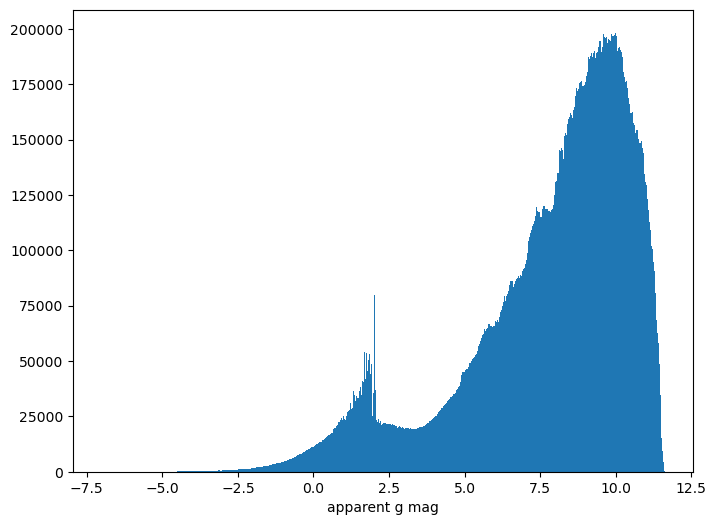

In [54]:
# Histogram of app g mag 
plt.figure(figsize=(8, 6))
plt.hist(g_mag, bins=1000)

plt.xlabel("apparent g mag")

# Show the plot
plt.show()

In [55]:
# Try filter less than 10, more than 2.5. 

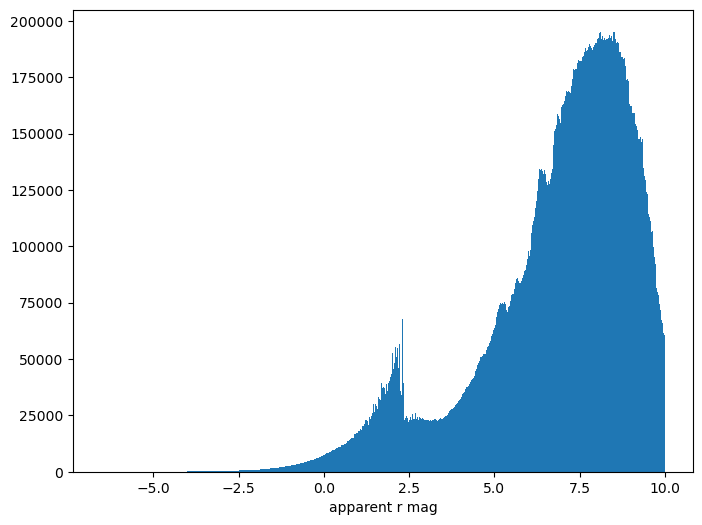

In [56]:
# Histogram of app r mag 

plt.figure(figsize=(8, 6))
plt.hist(r_mag, bins=1000)

plt.xlabel("apparent r mag")

# Show the plot
plt.show()

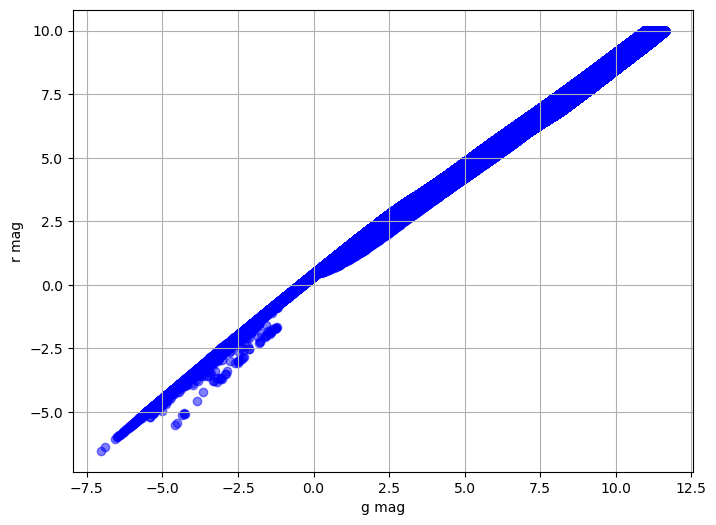

In [57]:
# TESTING - Compare g mag and r mag
plt.figure(figsize=(8, 6))
plt.scatter(g_mag, r_mag, alpha=0.5, color='blue')

# Set labels and title
plt.xlabel('g mag')
plt.ylabel('r mag')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

## Create $g-r$ vs $M_g$ Diagram

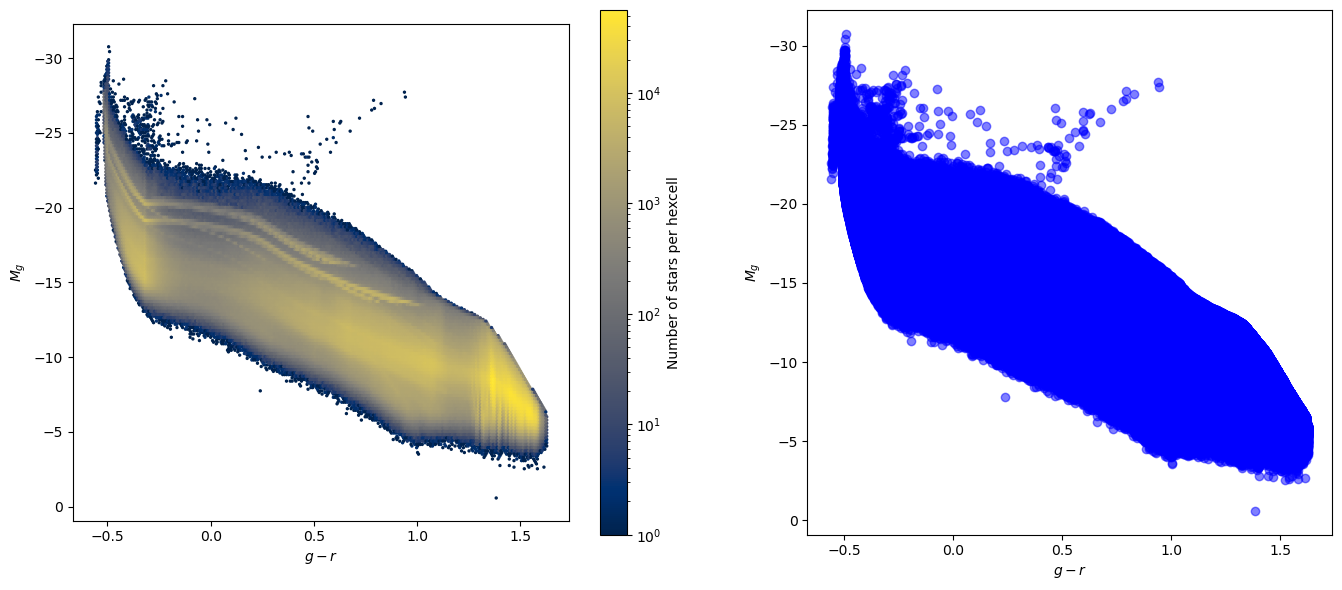

In [58]:
# FIRST PLOT USING DMOD

# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs[0].hexbin(g_minus_r, abs_mag_g, gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs[0].set_xlabel('$g - r$')
axs[0].set_ylabel('$M_g$')
axs[0].set_aspect(1.0/axs[0].get_data_ratio()) # Set aspect ratio
axs[0].invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs[0])
cbar.set_label('Number of stars per hexcell')

# Scatter plot for comparison
axs[1].scatter(g_minus_r, abs_mag_g, alpha=0.5, color='blue')
axs[1].set_xlabel('$g - r$')
axs[1].set_ylabel('$M_g$')
axs[1].set_aspect(1.0/axs[1].get_data_ratio()) # Set aspect ratio
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

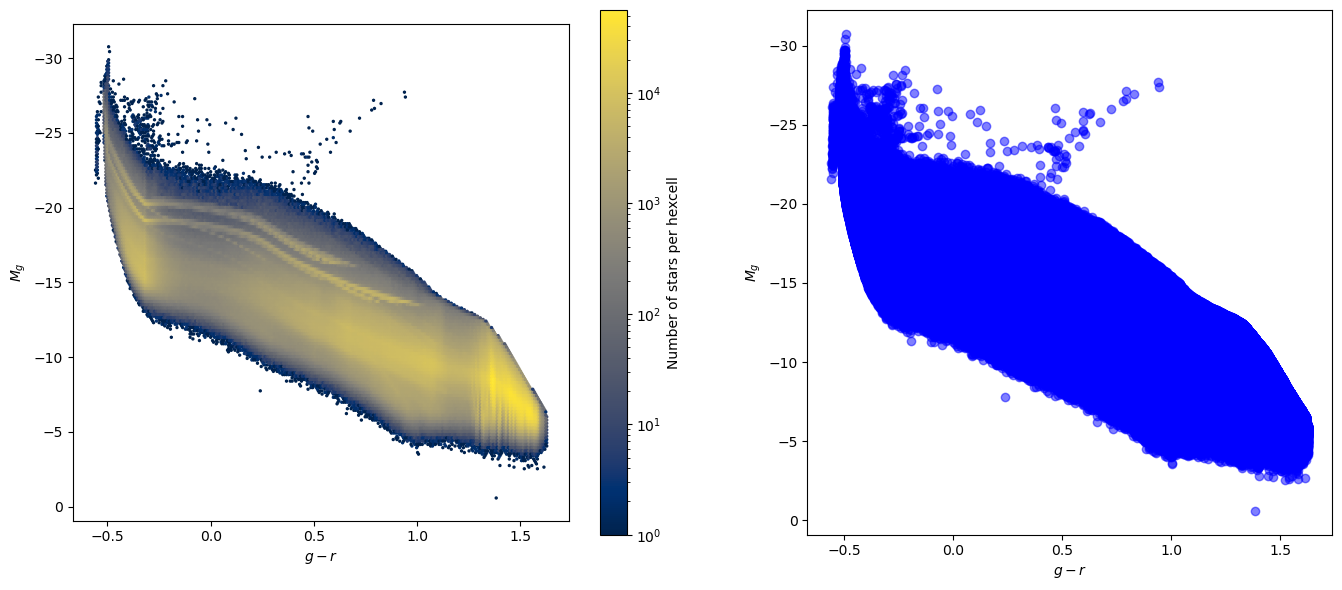

In [59]:
# SECOND PLOT USING DISTANCE

# Create the subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Create the hexbin, with 241 log bins and the hex_cmap colormap
hb = axs[0].hexbin(g_minus_r, abs_mag_g_2, gridsize=(241), bins='log', cmap=hex_cmap)

# Setting lables
axs[0].set_xlabel('$g - r$')
axs[0].set_ylabel('$M_g$')
axs[0].set_aspect(1.0/axs[0].get_data_ratio()) # Set aspect ratio
axs[0].invert_yaxis()

# Colorbar
cbar = fig.colorbar(hb, ax=axs[0])
cbar.set_label('Number of stars per hexcell')

# Scatter plot for comparison
axs[1].scatter(g_minus_r, abs_mag_g_2, alpha=0.5, color='blue')
axs[1].set_xlabel('$g - r$')
axs[1].set_ylabel('$M_g$')
axs[1].set_aspect(1.0/axs[1].get_data_ratio()) # Set aspect ratio
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [60]:
# Histogram of each band (g, r, i, u, y, z)